## Load up the environment variable needed for module imports

In [2]:
%env MIRA_REST_URL=http://34.230.33.149:8771

env: MIRA_REST_URL=http://34.230.33.149:8771


## Import modules

In [3]:
from mira.sources import biomodels
from mira.metamodel.comparison import *
from mira.metamodel.template_model import *
from mira.metamodel.templates import *
from mira.sources import biomodels

from itertools import combinations
from copy import deepcopy

## Define the Covid epi models to be compared and add them to a list 

In [28]:
COVID_MODEL_SET = {"BIOMD0000000955", "BIOMD0000000956", "BIOMD0000000957","BIOMD0000000958","BIOMD0000000960","BIOMD0000000962"}
rc = get_dkg_refinement_closure()

tm_covid_grounding_list = []
for covid_model in COVID_MODEL_SET:
    tm_covid_grounding_list.append(biomodels.get_template_model(covid_model))

## Compute pairwise similarity scores between each grounded model

In [34]:
tm_covid_comparison = TemplateModelComparison(tm_covid_grounding_list,refinement_func=rc.is_ontological_child)
tm_covid_comparison.model_comparison.get_similarity_scores()

Comparing model templates: 946it [00:00, 45401.42it/s]
Comparing model concepts: 595it [00:00, 112440.23it/s]


[{'models': (0, 1), 'score': 0.625},
 {'models': (0, 2), 'score': 0.125},
 {'models': (0, 3), 'score': 0.5},
 {'models': (0, 4), 'score': 0.625},
 {'models': (0, 5), 'score': 0.5},
 {'models': (1, 2), 'score': 0.4375},
 {'models': (1, 3), 'score': 0.625},
 {'models': (1, 4), 'score': 0.4375},
 {'models': (1, 5), 'score': 0.75},
 {'models': (2, 3), 'score': 0.625},
 {'models': (2, 4), 'score': 0.125},
 {'models': (2, 5), 'score': 0.75},
 {'models': (3, 4), 'score': 0.4375},
 {'models': (3, 5), 'score': 0.875},
 {'models': (4, 5), 'score': 0.4375}]

## Create image comparing selected grounded models

We choose to compare the second and fifth template model

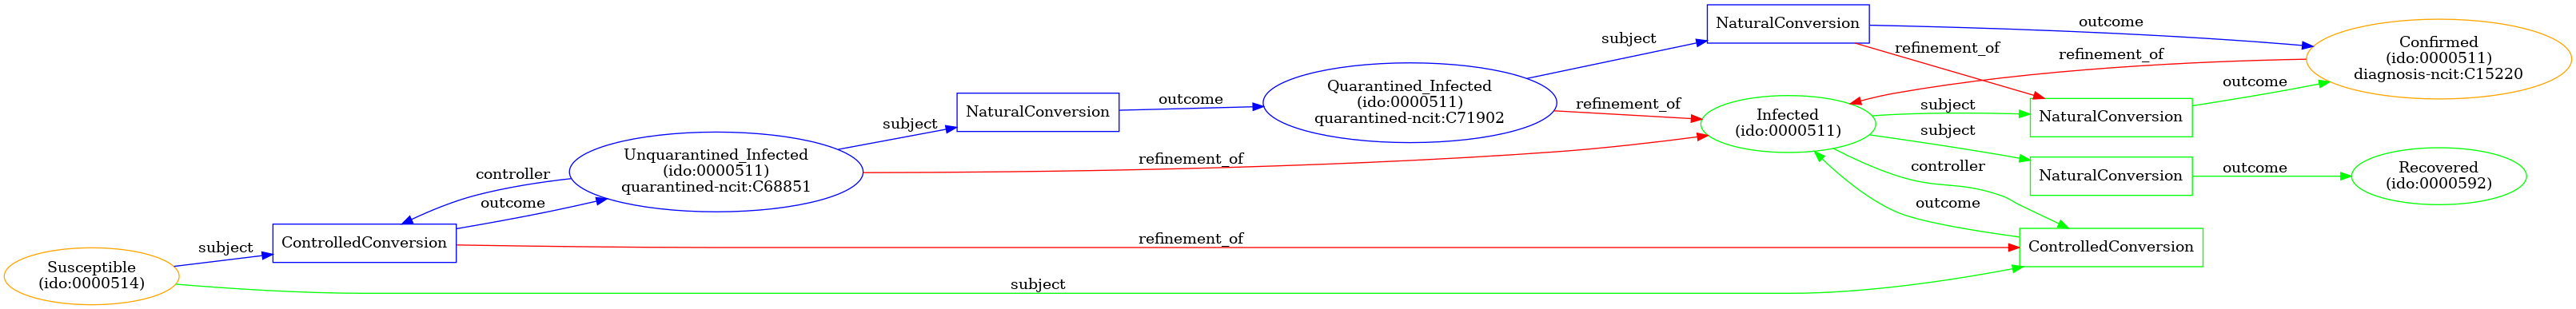

In [41]:
TemplateModelDelta.for_jupyter(tm_covid_comparison.template_models[2],tm_covid_comparison.template_models[5],
                                               rc.is_ontological_child,name=f"model_{2}{5}_grounding.png")

## Create a list of covid models without grounding 

In [45]:
tm_covid_no_grounding_list = [] 
for tm in tm_covid_grounding_list:
    copied_tm = deepcopy(tm)
    for template in copied_tm.templates:
        for concept in template.get_concepts():
            concept.identifiers = {}
    tm_covid_no_grounding_list.append(copied_tm)

## Compute pairwise similarity scores between each ungrounded model

In [47]:
tm_covid_comparison_copy = TemplateModelComparison(tm_covid_no_grounding_list,refinement_func=rc.is_ontological_child)
tm_covid_comparison_copy.model_comparison.get_similarity_scores()

Comparing model templates: 946it [00:00, 62507.86it/s]
Comparing model concepts: 595it [00:00, 66752.55it/s]


[{'models': (0, 1), 'score': 0.125},
 {'models': (0, 2), 'score': 0.125},
 {'models': (0, 3), 'score': 0.25},
 {'models': (0, 4), 'score': 0.4375},
 {'models': (0, 5), 'score': 0.25},
 {'models': (1, 2), 'score': 0.125},
 {'models': (1, 3), 'score': 0.25},
 {'models': (1, 4), 'score': 0.125},
 {'models': (1, 5), 'score': 0.25},
 {'models': (2, 3), 'score': 0.25},
 {'models': (2, 4), 'score': 0.125},
 {'models': (2, 5), 'score': 0.25},
 {'models': (3, 4), 'score': 0.25},
 {'models': (3, 5), 'score': 0.75},
 {'models': (4, 5), 'score': 0.25}]

## Create image comparing selected ungrounded models

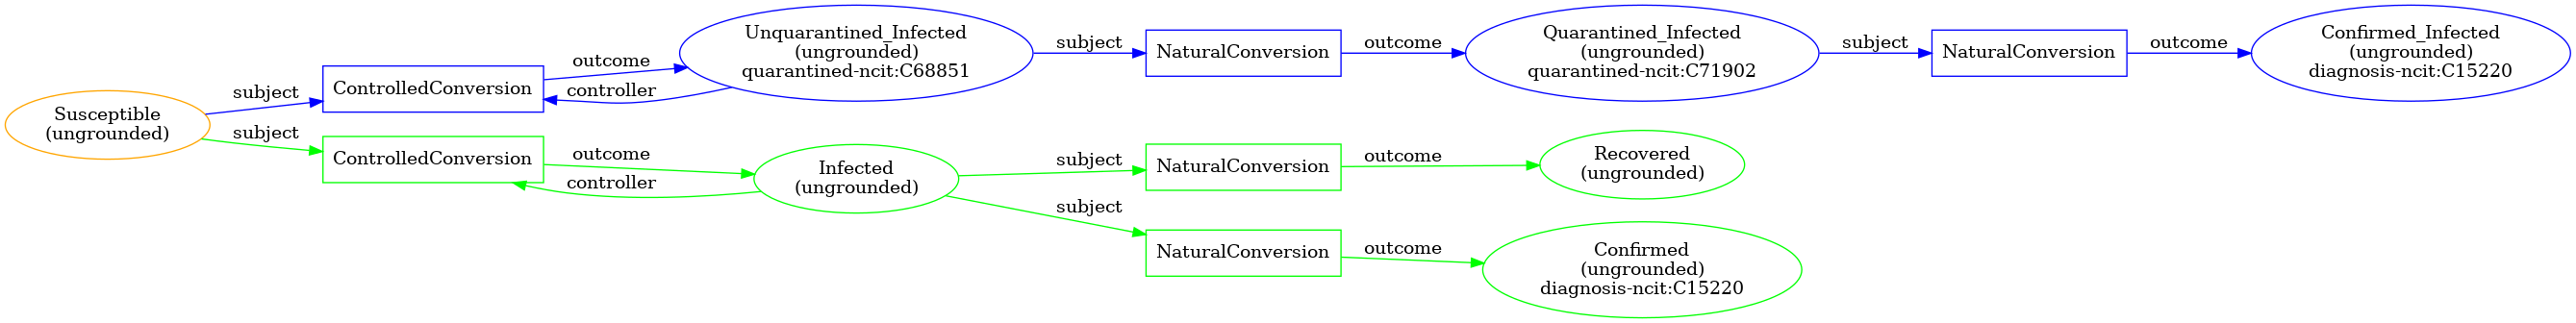

In [48]:
TemplateModelDelta.for_jupyter(tm_covid_comparison_copy.template_models[2],tm_covid_comparison_copy.template_models[5],
                                               rc.is_ontological_child,name=f"model_{2}{5}_no_grounding.png")

## Reasoning on difference between grounded and ungrounded models

The similarity score for models 2 and 5 when grounded is 0.75. The similarity score for the models when ungrounded is 0.25. The reasoning for this is because the refinements dissapear and the confirmed concept node is no longer the same between the two models